# 0. Setting for Analaysis 
## 0.1 Load packages


In [6]:
import os 
import pandas as pd 
import numpy as np
import math
import random 
import time 
import math 
from scipy import stats 
import matplotlib.pyplot as plt
from scipy.special import gamma, factorial
from scipy.special import psi

from sklearn.model_selection import train_test_split
import sklearn
import sklearn.pipeline
import sklearn.preprocessing

from sklearn.preprocessing import MinMaxScaler 
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import t

import  os
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings( 'ignore' )

## 0.1 Load Data Set
- credit_card data from kaggle (originally kdd-cup)


In [7]:
# REAL DATA FITTING (credit card data) ##############################
# 10만개로 만들어줌 #################################################
def real_data(n):
    import  os
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    import random
    
    FILE_PATH = "C:/Users/annie/Dropbox/Research/data"
    csv_path = os.path.join(FILE_PATH, "creditcard.csv")
    df = pd.read_csv(csv_path)
    # number of features = 30 (features, incl. time) + 1 (label)
    df = df.drop(['Time'], axis=1)   #drop time feature; number of input features = 29
    df_x_values = df.drop(['Class'], axis=1)
    
    ###### z-normalization 
    from sklearn.preprocessing import StandardScaler
    scaler1 = StandardScaler()
    df_x_scaled = scaler1.fit_transform(df_x_values)
    y = df.loc[:,['Class']]
    #y.describe()  # 0 normal, 1 anomaly 
    df_final = pd.concat([pd.DataFrame(df_x_scaled),pd.DataFrame(y)],axis=1) 
    #df_final.describe()
    cc_data = df_final.values    #convert pandas dataframe to numpy array
    cc_data.shape  # shape -> (284807, 30)
    cc_data_normal1 = cc_data[cc_data[:,29]==0]    #without 'Time'
    cc_data_normal2 = pd.DataFrame(cc_data_normal1).sample(n)
    cc_data_normal = np.array(cc_data_normal2)
    cc_data_fraud = cc_data[cc_data[:,29]==1]
    # without Time feature
    train_total_data_normal, test_total_data_normal, y_train_normal, y_test_normal = train_test_split(
    cc_data_normal, cc_data_normal[:,29], test_size=0.1 ,random_state=1004)
    
    #############################################################################################
    import sklearn
    import sklearn.pipeline
    import sklearn.preprocessing   
    def process_state(state):
        scaled = scaler.transform(state)
        return scaled
    #################################################################    
    cc_data_full_final = np.concatenate((cc_data_normal[:,:29],cc_data_fraud[:,:29]), axis=0)
    total_training_instances = len(train_total_data_normal)
    test_total_data = np.concatenate((cc_data_fraud, test_total_data_normal), axis=0)



    return train_total_data_normal, test_total_data_normal, y_train_normal, y_test_normal, test_total_data, total_training_instances, train_total_data_normal,test_total_data, cc_data_full_final 


# 1. DASKNMIX model 
## 1.1 Model for no batches


In [11]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


from SKNM import *

def dasknmixem(train_total_data_normal, test_total_data_normal, y_train_normal, y_test_normal, total_training_instances, 
             test_total_data, cc_data_full_final, 
            n_epochs=50, z_dim=1,k_dim=3, lr=0.001, batch_size=1024, n_hidden1=25, n_hidden2=20, n_hidden3=10, 
             n_layer1=10, lamda1=0.1, thres_point=0.99):
    #######################################################################################
    
    import tensorflow as tf
    import numpy as np
    from scipy.optimize import minimize_scalar
    from sklearn.mixture import GaussianMixture
    from numpy import random

    tf.reset_default_graph() 
    #그래프 초기화 bias/weight initial 돌릴때마다 새로 줄거기때문 
    training = tf.placeholder_with_default(False, shape=())   
    
    
    def encoder(x, z_dim, n_hidden1, n_hidden2, n_hidden3, dropout_prob_paper):

        with tf.variable_scope("encoder"):
            init_xavier = tf.contrib.layers.xavier_initializer()
            #he_init = tf.contrib.layers.variance_scaling_initializer()
            hidden1 = tf.layers.dense(x, n_hidden1, tf.nn.tanh, init_xavier)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, tf.nn.tanh, init_xavier)
            hidden2_drop = tf.layers.dropout(hidden2, dropout_prob, training=training)
            hidden3 = tf.layers.dense(hidden2_drop, n_hidden3, tf.nn.tanh, init_xavier)
            hidden3_drop = tf.layers.dropout(hidden3, dropout_prob, training=training)
            z_comp = tf.layers.dense(hidden3_drop,z_dim,None, init_xavier)
        return z_comp

    def decoder(z_comp, x_dim, n_hidden1, n_hidden2, n_hidden3,dropout_prob_paper, reuse=False):

        with tf.variable_scope("decoder"):
            init_xavier = tf.contrib.layers.xavier_initializer()
            #he_init = tf.contrib.layers.variance_scaling_initializer()
            hidden3 = tf.layers.dense(z_comp, n_hidden3, tf.nn.tanh, init_xavier)
            hidden3_drop = tf.layers.dropout(hidden3, dropout_prob, training=training)
            hidden2 = tf.layers.dense(hidden3_drop, n_hidden2, tf.nn.tanh, init_xavier)
            hidden2_drop = tf.layers.dropout(hidden2, dropout_prob, training=training)
            hidden1 = tf.layers.dense(hidden2_drop, n_hidden1, tf.nn.tanh, init_xavier)
            x_hat_logits = tf.layers.dense(hidden1, x_dim, None, init_xavier)
            #x_hat_sigmoid = tf.sigmoid(x_hat_logits)
        return x_hat_logits
         
    
    def skewem(z, k_dims):
        max_attempts = 3  # 최대 재시도 횟수
        best_log_lik = None
        best_w, best_ksi, best_sigma, best_lambd = None, None, None, None

        for _ in range(max_attempts):
            try:
                w, ksi, sigma, lambd, log_lik = sknm_em_diag(z, k_dims, tol=1e-4, max_iter=10)
                if best_log_lik is None or log_lik > best_log_lik:
                    best_log_lik = log_lik
                    best_w, best_ksi, best_sigma, best_lambd = w, ksi, sigma, lambd
            except Exception as e:
                print(f"An error occurred: {e}")
                print("Restarting the EM algorithm...")
                continue

        if best_log_lik is not None:
            return best_w, best_ksi, best_sigma, best_lambd
        else:
            raise RuntimeError("Failed to converge after multiple attempts")
    
    
    def compression_autoencoder(x, x_dim, z_dim, n_hidden1, n_hidden2, n_hidden3, dropout_prob):
        
        z_comp = encoder(x, z_dim, n_hidden1, n_hidden2, n_hidden3, dropout_prob)
        x_hat = decoder(z_comp, x_dim, n_hidden1, n_hidden2, n_hidden3, dropout_prob)
        
    
        #relative euclidean distance --------------------------------------------
        ae_loss = tf.reduce_mean(tf.squared_difference(x,x_hat)) 
        recon_error = x - x_hat
        
        # euclidean distance 
        recon_error_magnitude = tf.cast(tf.norm(
                recon_error, ord='euclidean', axis=1, keep_dims=True),tf.float32) #tensor of shape (batch_size, 1)
        
        recon_denom = tf.cast(tf.sqrt(tf.reduce_sum(tf.square(x),axis=1)),tf.float32)
      
        # relatvie euclidean distance로 코드 수정  -------------------------------
        # 10000 수정해줘야함 
        #recon_denom = tf.cast(tf.sqrt(tf.reduce_sum(tf.square(t1),axis=1)),tf.float32)
        rel_euclidean_temp = recon_error_magnitude / recon_denom 
        relative_euclidean = tf.transpose(tf.slice(rel_euclidean_temp, [1,0],[1,batch_size]))
        
        # cosine similarity ----------------------------------------------------
        x_unit = tf.nn.l2_normalize(x, dim=1)    
        x_hat_unit = tf.nn.l2_normalize(x_hat, dim=1)
        cos_similarity=tf.reduce_sum(
                   tf.multiply(x_unit ,x_hat_unit),axis=1,keep_dims=True) #shape = (batch_size,1)

      
        return z_comp, x_hat, ae_loss, recon_error_magnitude, cos_similarity 
    
    
    
    def energy_density(z_val, w, ksi, sigma, lambd ):
        likelihood = np.sum(np.array(list(map(sknm_pdf, [z_val] * len(w), w, ksi, sigma, lambd))),axis=0)
        energy_value = -np.log(likelihood)
        energy_value_tensor = tf.convert_to_tensor(energy_value, dtype=np.float32)
        
        return  energy_value
    
  ##################################################################################
    
    def threshold_func(energy_input, location):
        
        energy_sort = np.sort(energy_input, axis=0)
        count, bins_count = np.histogram(energy_sort, bins=100) # 0.8 부터 가파르게 오름 
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        
        thres_loc = int(len(energy_sort)*location)
        threshold = energy_sort[thres_loc]
        plt.plot(bins_count[1:], cdf, label = "CDF") 

        return threshold 

  ##################################################################################

    from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

    # threshold (energy cdf 가파르게 올라가는 지점 기준으로 임계값): 임계값 구하기 
    # confusion matrix 
    def get_confusion_matrix_values(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

    def f1_func(labels, energy_input, thres):
        
        prediction = (energy_input >= thres).astype(int)
        pred = prediction.reshape(-1)
        real_labels = labels.astype(int)
        
        confusion = confusion_matrix(real_labels, pred)
        accuracy = accuracy_score(real_labels, pred) 
        precision = precision_score(real_labels, pred)
        recall = recall_score(real_labels, pred)
        f1 = f1_score(real_labels, pred)
        
        TN, FP, FN, TP = get_confusion_matrix_values(real_labels, pred)
    
        
        #print('f1:{}, 정밀도:{}, 재현율:{}'.format(f1, precision, recall))
        #print(confusion)
        #print(TP,FP,FN,TN)
        return f1, precision, recall, TP, FP, FN, TN 

    def find_optimal_threshold(test_labels, energy_value_test, energy_value_full):
        f1_scores = []  # F1 스코어를 저장할 리스트
        thres_points = []  # thres_point 값을 저장할 리스트

        for thres_point in np.arange(0.6, 1, 0.001):  # 예시: 0부터 1까지 0.01 간격으로 시도
            thres = threshold_func(energy_value_full, thres_point)
            f1_result, _, _, _, _, _, _ = f1_func(test_labels, energy_value_test, thres)

            f1_scores.append(f1_result)
            thres_points.append(thres_point)

        max_f1_index = np.argmax(f1_scores)  # 최대 F1 스코어의 인덱스 찾기
        best_threshold = thres_points[max_f1_index]  # 해당 인덱스에 대응하는 thres_point 값 찾기
        best_f1_score = f1_scores[max_f1_index]  # 최대 F1 스코어 찾기

        return best_threshold    ###############################################################################
 
    x_dim = cc_data_full_final.shape[1]
    d = z_dim+2  #z_dim임 
    
    dropout_prob = tf.placeholder(tf.float32, name='dropout_prob')
    dropout_prob_paper = tf.placeholder(tf.float32, name='dropout_prob_paper')
    
    x = tf.placeholder(tf.float32, shape=[None, x_dim]) #input data 형태 만들어줌
    energy = tf.placeholder(tf.float32, shape=[None, ])

    z_comp, x_hat, ae_loss, recon_error_magnitude, cos_similarity = compression_autoencoder(x, x_dim, z_dim, n_hidden1, n_hidden2, n_hidden3, dropout_prob)
    
    z_concat =  tf.concat([z_comp, recon_error_magnitude , cos_similarity ], axis=1)
    
    energy_loss = tf.reduce_mean(energy) 
    
    total_loss = ae_loss + lamda1*energy_loss 
    
    #total_loss_box = []
    #ae_loss_box = []
    #total_loss_test_box = []
    #ae_loss_test_box = []

    
    # training은 weight/bias update를 위함. 따라서, network 있는 곳만 optimization 
    t_vars = tf.trainable_variables()
    all_training_vars = [var for var in t_vars if "encoder" or "decoder" in var.name]
    training_op = tf.train.AdamOptimizer(lr).minimize(total_loss, var_list= all_training_vars)
    number_of_batches = int(total_training_instances / batch_size)
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        
        #np.random.shuffle(train_total_data_normal) # batch 돌릴때 

        np.random.shuffle(train_total_data_normal) 
        train_data_ = train_total_data_normal[:, 0:x_dim]
        train_label_ = train_total_data_normal[:, x_dim]
        # test data #####################################
        test_data = test_total_data[:,0:x_dim]
        test_labels = test_total_data[:,x_dim]
        ######################################          
                
        z_val = sess.run((z_concat),feed_dict={x: train_data_,
                                               dropout_prob : 0.0,
                                               dropout_prob_paper : 0.0,
                                               training: False})

        ws, ksis, sigmas, lambds = skewem(z_val, k_dim)        

        energy_value = energy_density(z_val, ws, ksis, sigmas, lambds)


        _,  total_loss_val, ae_loss_val  = sess.run((training_op, total_loss,ae_loss),
                                                    feed_dict={x: train_data_,
                                                               energy: energy_value,
                                                               dropout_prob : 0.5,
                                                               dropout_prob_paper : 0.5,
                                                               training: True})

# finish training 
# for EM algorithm -----------------------------------------------------------------------------------------------------
# start testing 

        
        z_val_new = sess.run((z_concat),feed_dict={x: train_data_ ,
                                                   dropout_prob : 0.0,
                                                   dropout_prob_paper : 0.0,
                                                   training: False})
      
        w_new, ksi_new, sigma_new, lambd_new = skewem(z_val_new, k_dim) 
        #print("dof_new", dof_new)

        energy_value_new = energy_density(z_val_new, w_new, ksi_new, sigma_new, lambd_new)       
        
        #for comparision -------------------------------------------------------------------------------------------------------
        
        #total_loss 
        total_loss_val = sess.run((total_loss), 
                                  feed_dict={x: train_data_,
                                             energy: energy_value_new,
                                             dropout_prob : 0.0,
                                             dropout_prob_paper : 0.0,
                                             training: False})
        
        # ae_loss 
        ae_loss_value = sess.run((ae_loss),
                                 feed_dict={x: train_data_,
                                            energy: energy_value_new,
                                            dropout_prob : 0.0, 
                                            dropout_prob_paper : 0.0,
                                            training: False})

    
        # test value ----------------------------------------------------------------------------------------------------------
        
        z_val_test = sess.run((z_concat),feed_dict={x: test_data,
                                                    dropout_prob : 0.0,
                                                    dropout_prob_paper : 0.0,
                                                    training: False})
                
        energy_value_test = energy_density(z_val_test, w_new, ksi_new, sigma_new, lambd_new)
        
        # for threshold 
        
        z_val_full = sess.run((z_concat),feed_dict={x: cc_data_full_final,
                                                    dropout_prob : 0.0,
                                                    dropout_prob_paper : 0.0,
                                                    training: False})
                
        energy_value_full = energy_density(z_val_full, w_new, ksi_new, sigma_new, lambd_new)
        energy_value_full = energy_density(z_val_full, w_new, ksi_new, sigma_new, lambd_new)   
        energy_value_full[energy_value_full == np.inf] = np.max(energy_value_full[energy_value_full != np.inf])  
        
        best_threshold = find_optimal_threshold(test_labels, energy_value_test, energy_value_full)
        thres = threshold_func(energy_value_full, best_threshold)
        f1_result, precision_result, recall_result, TP_result, FP_result, FN_result, TN_result  = f1_func(test_labels, energy_value_test, thres)
        
    return z_val_full, f1_result, precision_result, recall_result, total_loss_val, ae_loss_value, TP_result, FP_result, FN_result, TN_result, energy_value_test, best_threshold     


    




## 1.2 Model for batches
- 배치 있는 모형


In [12]:
from SKNM import *

def dasknmixem_b(train_total_data_normal, test_total_data_normal, y_train_normal, y_test_normal, total_training_instances, test_total_data, cc_data_full_final, 
            n_epochs=50, z_dim=1, lr=0.001, batch_size=1024, n_hidden1=25, n_hidden2=20, n_hidden3=10, n_layer1=10, lamda1=0.1, thres_point=0.99):
    #######################################################################################
    
    import tensorflow as tf
    import numpy as np
    from scipy.optimize import minimize_scalar
    from sklearn.mixture import GaussianMixture
    from numpy import random

    tf.reset_default_graph() 
    #그래프 초기화 bias/weight initial 돌릴때마다 새로 줄거기때문 
    training = tf.placeholder_with_default(False, shape=())   
    
    
    def encoder(x, z_dim, n_hidden1, n_hidden2, n_hidden3, dropout_prob_paper):

        with tf.variable_scope("encoder"):
            init_xavier = tf.contrib.layers.xavier_initializer()
            #he_init = tf.contrib.layers.variance_scaling_initializer()
            hidden1 = tf.layers.dense(x, n_hidden1, tf.nn.tanh, init_xavier)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, tf.nn.tanh, init_xavier)
            hidden2_drop = tf.layers.dropout(hidden2, dropout_prob, training=training)
            hidden3 = tf.layers.dense(hidden2_drop, n_hidden3, tf.nn.tanh, init_xavier)
            hidden3_drop = tf.layers.dropout(hidden3, dropout_prob, training=training)
            z_comp = tf.layers.dense(hidden3_drop,z_dim,None, init_xavier)
        return z_comp

    def decoder(z_comp, x_dim, n_hidden1, n_hidden2, n_hidden3,dropout_prob_paper, reuse=False):

        with tf.variable_scope("decoder"):
            init_xavier = tf.contrib.layers.xavier_initializer()
            #he_init = tf.contrib.layers.variance_scaling_initializer()
            hidden3 = tf.layers.dense(z_comp, n_hidden3, tf.nn.tanh, init_xavier)
            hidden3_drop = tf.layers.dropout(hidden3, dropout_prob, training=training)
            hidden2 = tf.layers.dense(hidden3_drop, n_hidden2, tf.nn.tanh, init_xavier)
            hidden2_drop = tf.layers.dropout(hidden2, dropout_prob, training=training)
            hidden1 = tf.layers.dense(hidden2_drop, n_hidden1, tf.nn.tanh, init_xavier)
            x_hat_logits = tf.layers.dense(hidden1, x_dim, None, init_xavier)
            #x_hat_sigmoid = tf.sigmoid(x_hat_logits)
        return x_hat_logits
         
    

    def skewem(z,k_dim): 
        w, ksi, sigma, lambd, _ =  sknm_em_diag(z, k_dim, tol=1e-4, max_iter=100)
        return w, ksi, sigma, lambd
    
    
    def compression_autoencoder(x, x_dim, z_dim, n_hidden1, n_hidden2, n_hidden3, dropout_prob):
        
        z_comp = encoder(x, z_dim, n_hidden1, n_hidden2, n_hidden3, dropout_prob)
        x_hat = decoder(z_comp, x_dim, n_hidden1, n_hidden2, n_hidden3, dropout_prob)
        
    
        #relative euclidean distance --------------------------------------------
        ae_loss = tf.reduce_mean(tf.squared_difference(x,x_hat)) 
        recon_error = x - x_hat
        
        # euclidean distance 
        recon_error_magnitude = tf.cast(tf.norm(
                recon_error, ord='euclidean', axis=1, keep_dims=True),tf.float32) #tensor of shape (batch_size, 1)
        
        recon_denom = tf.cast(tf.sqrt(tf.reduce_sum(tf.square(x),axis=1)),tf.float32)
      
        # relatvie euclidean distance로 코드 수정  -------------------------------
        # 10000 수정해줘야함 
        #recon_denom = tf.cast(tf.sqrt(tf.reduce_sum(tf.square(t1),axis=1)),tf.float32)
        rel_euclidean_temp = recon_error_magnitude / recon_denom 
        relative_euclidean = tf.transpose(tf.slice(rel_euclidean_temp, [1,0],[1,batch_size]))
        
        # cosine similarity ----------------------------------------------------
        x_unit = tf.nn.l2_normalize(x, dim=1)    
        x_hat_unit = tf.nn.l2_normalize(x_hat, dim=1)
        cos_similarity=tf.reduce_sum(
                   tf.multiply(x_unit ,x_hat_unit),axis=1,keep_dims=True) #shape = (batch_size,1)

      
        return z_comp, x_hat, ae_loss, recon_error_magnitude, cos_similarity 
    
    

    def energy_density(z_val, w, ksi, sigma, lambd ):
        likelihood = np.sum(np.array(list(map(sknm_pdf, [z_val] * len(w), w, ksi, sigma, lambd))),axis=0)
        energy_value = -np.log(likelihood)
        energy_value_tensor = tf.convert_to_tensor(energy_value, dtype=np.float32)
        
        return  energy_value
    
  ##################################################################################
    
    def threshold_func(energy_input, location):
        energy_sort = np.sort(energy_input)
        count, bins_count = np.histogram(energy_sort, bins=100) # 0.8 부터 가파르게 오름 
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        thres_loc = int(len(energy_sort)*location)
        threshold = energy_sort[thres_loc]
        plt.plot(bins_count[1:], cdf, label = "CDF") 
        return threshold

  ##################################################################################

    from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

    # threshold (energy cdf 가파르게 올라가는 지점 기준으로 임계값): 임계값 구하기 
    # confusion matrix 
    def get_confusion_matrix_values(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

    def f1_func(labels, energy_input, thres):
        
        prediction = (energy_input >= thres).astype(int)
        pred = prediction.reshape(-1)
        real_labels = labels.astype(int)
        
        confusion = confusion_matrix(real_labels, pred)
        accuracy = accuracy_score(real_labels, pred) 
        precision = precision_score(real_labels, pred)
        recall = recall_score(real_labels, pred)
        f1 = f1_score(real_labels, pred)
        
        TN, FP, FN, TP = get_confusion_matrix_values(real_labels, pred)
    
        
        #print('f1:{}, 정밀도:{}, 재현율:{}'.format(f1, precision, recall))
        #print(confusion)
        #print(TP,FP,FN,TN)
        return f1, precision, recall, TP, FP, FN, TN 
    
    def find_optimal_threshold(test_labels, energy_value_test, energy_value_full):
        f1_scores = []  # F1 스코어를 저장할 리스트
        thres_points = []  # thres_point 값을 저장할 리스트

        for thres_point in np.arange(0, 1, 0.001):  # 예시: 0부터 1까지 0.01 간격으로 시도
            thres = threshold_func(energy_value_full, thres_point)
            f1_result, _, _, _, _, _, _ = f1_func(test_labels, energy_value_test, thres)

            f1_scores.append(f1_result)
            thres_points.append(thres_point)

        max_f1_index = np.argmax(f1_scores)  # 최대 F1 스코어의 인덱스 찾기
        best_threshold = thres_points[max_f1_index]  # 해당 인덱스에 대응하는 thres_point 값 찾기
        best_f1_score = f1_scores[max_f1_index]  # 최대 F1 스코어 찾기

        return best_threshold
    ###############################################################################
 
    x_dim = cc_data_full_final.shape[1]
    d = z_dim+2  #z_dim임 
    dropout_prob = tf.placeholder(tf.float32, name='dropout_prob')
    dropout_prob_paper = tf.placeholder(tf.float32, name='dropout_prob_paper') 
    x = tf.placeholder(tf.float32, shape=[None, x_dim]) #input data 형태 만들어줌
    energy = tf.placeholder(tf.float32, shape=[None, ])
    z_comp, x_hat, ae_loss, recon_error_magnitude, cos_similarity = compression_autoencoder(x, x_dim, z_dim, n_hidden1, n_hidden2, n_hidden3, dropout_prob)
    z_concat =  tf.concat([z_comp, recon_error_magnitude , cos_similarity ], axis=1)
    energy_loss = tf.reduce_mean(energy) 
    total_loss = ae_loss + lamda1*energy_loss 
    
    # training은 weight/bias update를 위함. 따라서, network 있는 곳만 optimization 
    t_vars = tf.trainable_variables()
    all_training_vars = [var for var in t_vars if "encoder" or "decoder" in var.name]
    training_op = tf.train.AdamOptimizer(lr).minimize(total_loss, var_list= all_training_vars)
    number_of_batches = int(total_training_instances / batch_size)
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        
        #np.random.shuffle(train_total_data_normal) # batch 돌릴때 
        
        for epoch in range(n_epochs):
            
            np.random.shuffle(train_total_data_normal) 
            train_data_ = train_total_data_normal[:, 0:x_dim]
            train_label_ = train_total_data_normal[:, x_dim]
            # test data #####################################
            test_data = test_total_data[:,0:x_dim]
            test_labels = test_total_data[:,x_dim]
            ######################################
            
            for i in range(number_of_batches): 
                
                offset = (i * batch_size) % (total_training_instances)
                batch_x_input = train_data_[offset:(offset + batch_size), :]
                
                z_val = sess.run((z_concat),feed_dict={x: batch_x_input, dropout_prob : 0.0,dropout_prob_paper : 0.0,training: False})
                
                ws, ksis, sigmas, lambds = skewem(z_val, k_dims)        

                energy_value = energy_density(z_val, ws, ksis, sigmas, lambds)

        
                _,  total_loss_val, ae_loss_val  = sess.run((training_op, total_loss,ae_loss),
                                                            feed_dict={x: batch_x_input,
                                                                       energy: energy_value,
                                                                       dropout_prob : 0.5,
                                                                       dropout_prob_paper : 0.5,
                                                                       training: True})
                

        # finish training 
        # for EM algorithm -----------------------------------------------------------------------------------------------------
        # start testing 
        
        
        z_val_new = sess.run((z_concat),feed_dict={x: train_data_ ,
                                                   dropout_prob : 0.0,
                                                   dropout_prob_paper : 0.0,
                                                   training: False})
      
        ws, ksis, sigmas, lambds = skewem(z_val, k_dim)        

        energy_value = energy_density(z_val, ws, ksis, sigmas, lambds)      
        
        #for comparision -------------------------------------------------------------------------------------------------------
        
        #total_loss 
        total_loss_val = sess.run((total_loss), 
                                  feed_dict={x: train_data_,
                                             energy: energy_value_new,
                                             dropout_prob : 0.0,
                                             dropout_prob_paper : 0.0,
                                             training: False})
        
        # ae_loss 
        ae_loss_value = sess.run((ae_loss),
                                 feed_dict={x: train_data_,
                                            energy: energy_value_new,
                                            dropout_prob : 0.0, 
                                            dropout_prob_paper : 0.0,
                                            training: False})

    
        # test value ----------------------------------------------------------------------------------------------------------
        
        z_val_test = sess.run((z_concat),feed_dict={x: test_data,
                                                    dropout_prob : 0.0,
                                                    dropout_prob_paper : 0.0,
                                                    training: False})
        
        w_new, ksi_new, sigma_new, lambd_new = skewem(z_val_test, k_dim) 

        energy_value_new = energy_density(z_val_test, w_new, ksi_new, sigma_new, lambd_new)   
        
        # for threshold 
        
        z_val_full = sess.run((z_concat),feed_dict={x: cc_data_full_final,
                                                    dropout_prob : 0.0,
                                                    dropout_prob_paper : 0.0,
                                                    training: False})
                
        energy_value_full = energy_density(z_val_full, w_new, ksi_new, sigma_new, lambd_new)   
        energy_value_full[energy_value_full == np.inf] = np.max(energy_value_full[energy_value_full != np.inf])  
        
        best_threshold = find_optimal_threshold(test_labels, energy_value_test, energy_value_full)
        thres = threshold_func(energy_value_full, best_threshold)
        f1_result, precision_result, recall_result, TP_result, FP_result, FN_result, TN_result  = f1_func(test_labels, energy_value_test, thres)
        
    return z_val_full, f1_result, precision_result, recall_result, total_loss_val, ae_loss_value, TP_result, FP_result, FN_result, TN_result, energy_value_test, best_threshold        ,
    




# 2. 데이터 적용
## 2.1 batches

0
f1_score 0.9068577277379734 FPR_avg = 0.084 precision_avg = 0.9134020618556701 recall_avg = 0.9004065040650406 TP_avg= 443 FP_avg= 42 FN_avg= 49 TN_avg= 458 Best_Threshold= 0.8420000000000002
1
f1_score 0.9064748201438848 FPR_avg = 0.08 precision_avg = 0.9168399168399168 recall_avg = 0.8963414634146342 TP_avg= 441 FP_avg= 40 FN_avg= 51 TN_avg= 460 Best_Threshold= 0.8510000000000002
2
f1_score 0.9085303186022611 FPR_avg = 0.078 precision_avg = 0.918918918918919 recall_avg = 0.8983739837398373 TP_avg= 442 FP_avg= 39 FN_avg= 50 TN_avg= 461 Best_Threshold= 0.8480000000000002
3
f1_score 0.8969823100936524 FPR_avg = 0.076 precision_avg = 0.9189765458422174 recall_avg = 0.8760162601626016 TP_avg= 431 FP_avg= 38 FN_avg= 61 TN_avg= 462 Best_Threshold= 0.8640000000000002
4
f1_score 0.9003083247687564 FPR_avg = 0.086 precision_avg = 0.9106029106029107 recall_avg = 0.8902439024390244 TP_avg= 438 FP_avg= 43 FN_avg= 54 TN_avg= 457 Best_Threshold= 0.8470000000000002
5
f1_score 0.9081419624217119 FP

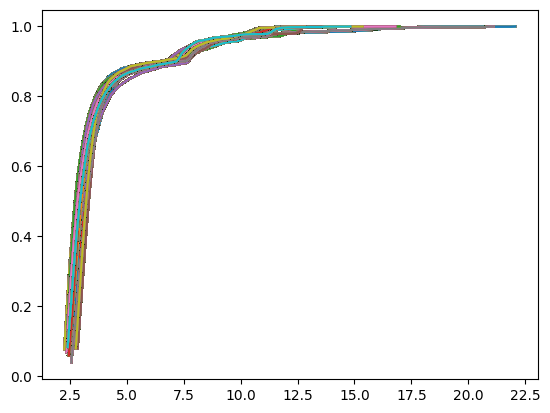

In [13]:
#lambda = 0.013, 1 

num_of_for = 20


ae_loss = np.zeros(shape=(num_of_for,1))
f1_value = np.zeros(shape=(num_of_for,1))
total_loss = np.zeros(shape=(num_of_for,1))
prec_value = np.zeros(shape=(num_of_for,1))
recal_value = np.zeros(shape=(num_of_for,1))

TP_value = np.zeros(shape=(num_of_for,1))
FP_value = np.zeros(shape=(num_of_for,1))
FN_value = np.zeros(shape=(num_of_for,1))
TN_value = np.zeros(shape=(num_of_for,1))
Thres = np.zeros(shape=(num_of_for,1))                   

math.factorial(1234567) 
start = time.time() 

#mu_full = pd.DataFrame()
for i in range(0, num_of_for):
    np.random.seed(7)
    print(i)
    train_total_data_normal, test_total_data_normal, y_train_normal,y_test_normal, test_total_data, total_training_instances, train_total_data_normal,test_total_data, cc_data_full_final = real_data(5000)
    z_vec, f1_score, precision_val, recall_val,  loss_val, ae_loss_val, TP_val, FP_val, FN_val, TN_val, energy_value, best_thres     =  dasknmixem(train_total_data_normal, test_total_data_normal, y_train_normal, y_test_normal, total_training_instances, 
                                                                                                                                                test_total_data, cc_data_full_final, n_epochs=50, z_dim=1,k_dim=3, lr=0.001, batch_size=1024, n_hidden1=25, n_hidden2=20, n_hidden3=10, n_layer1=10, lamda1=0.1, thres_point=0.99)    
    print("f1_score", f1_score,
          "FPR_avg =", (FP_val)/(FP_val+TN_val),
          "precision_avg =", precision_val,
          "recall_avg =", recall_val,
          "TP_avg=", TP_val,
          "FP_avg=", FP_val,
          "FN_avg=", FN_val,
          "TN_avg=", TN_val,
          "Best_Threshold=",best_thres)
        
    ae_loss[i] = ae_loss_val 
    f1_value[i] = f1_score
    
    total_loss[i] = loss_val 
    prec_value[i] = precision_val 
    recal_value[i] = recall_val
    
    TP_value[i] = TP_val 
    FP_value[i] = FP_val
    FN_value[i] = FN_val
    TN_value[i] = TN_val
    Thres[i] = best_thres           


print("f1_score_avg =", np.mean(f1_value),
      "f1_var=", np.var(f1_value),
      "precision_avg =", np.mean(prec_value),
      "recall_avg =", np.mean(recal_value),
      "FPR_avg =", np.mean(FP_value)/(np.mean(FP_value)+np.mean(TN_value)),
      "TP_avg=", np.mean(TP_value),
      "FP_avg=", np.mean(FP_value),
      "FN_avg=", np.mean(FN_value),
      "TN_avg=", np.mean(TN_value),
     "Thres_avg=",np.mean(Thres))

end = time.time() 
print(f"{end-start:.5f} sec")

#(pd.DataFrame(f1_value)).to_csv("DASKNMIX_credit_F1.csv")

## 2.2  batches exist

In [14]:
def real_data_sat(n):
    import  os
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    import random
    import sklearn
    import sklearn.pipeline
    import sklearn.preprocessing

    FILE_PATH = "C:/Users/annie/Dropbox/Research/data"
    csv_path = os.path.join(FILE_PATH, "sat.csv")
    df = pd.read_csv(csv_path)
    df_x_values = df.drop(['label'], axis=1)
    # z-normalization 
    from sklearn.preprocessing import StandardScaler
    scaler1 = StandardScaler()
    df_x_scaled = scaler1.fit_transform(df_x_values)
    y = df.loc[:,['label']]
    df_final = pd.concat([pd.DataFrame(df_x_scaled),pd.DataFrame(y)],axis=1)

    cc_data = df_final.values    #convert pandas dataframe to numpy array
    cc_data.shape  # shape -> (284807, 30)
    cc_data_normal2 = cc_data[cc_data[:,36]==0]    #without 'Time'
    #cc_data_normal2 = pd.DataFrame(cc_data_normal1).sample(n)
    cc_data_normal = np.array(cc_data_normal2)    
    cc_data_fraud = cc_data[cc_data[:,36]==1]

    from sklearn.model_selection import train_test_split
    train_total_data_normal, test_total_data_normal, y_train_normal, y_test_normal = train_test_split(cc_data_normal, cc_data_normal[:,36], test_size=0.1, random_state=1004)

    def process_state(state):
        scaled = scaler.transform(state)
        return scaled
    cc_data_full_final = np.concatenate((cc_data_normal[:,:36],cc_data_fraud[:,:36]), axis=0)    
    total_training_instances = len(train_total_data_normal)
    test_total_data = np.concatenate((cc_data_fraud, test_total_data_normal), axis=0)
    
    return train_total_data_normal, test_total_data_normal, y_train_normal,y_test_normal, test_total_data, total_training_instances, train_total_data_normal,test_total_data, cc_data_full_final 


0
f1_score 0.7807637906647807 FPR_avg = 0.27045454545454545 precision_avg = 0.9206137424949966 recall_avg = 0.6777996070726916 TP_avg= 1380 FP_avg= 119 FN_avg= 656 TN_avg= 321 Best_Threshold= 0.6
1
f1_score 0.7803223070398644 FPR_avg = 0.275 precision_avg = 0.9193870752831446 recall_avg = 0.6777996070726916 TP_avg= 1380 FP_avg= 121 FN_avg= 656 TN_avg= 319 Best_Threshold= 0.6
2
f1_score 0.7985450475657527 FPR_avg = 0.25227272727272726 precision_avg = 0.9278283485045513 recall_avg = 0.7008840864440079 TP_avg= 1427 FP_avg= 111 FN_avg= 609 TN_avg= 329 Best_Threshold= 0.6
3
f1_score 0.8188585607940446 FPR_avg = 0.2409090909090909 precision_avg = 0.933375235700817 recall_avg = 0.7293713163064833 TP_avg= 1485 FP_avg= 106 FN_avg= 551 TN_avg= 334 Best_Threshold= 0.6
4
f1_score 0.800777993887191 FPR_avg = 0.2772727272727273 precision_avg = 0.9219449776071658 recall_avg = 0.7077603143418467 TP_avg= 1441 FP_avg= 122 FN_avg= 595 TN_avg= 318 Best_Threshold= 0.6
5
f1_score 0.7960784313725491 FPR_avg 

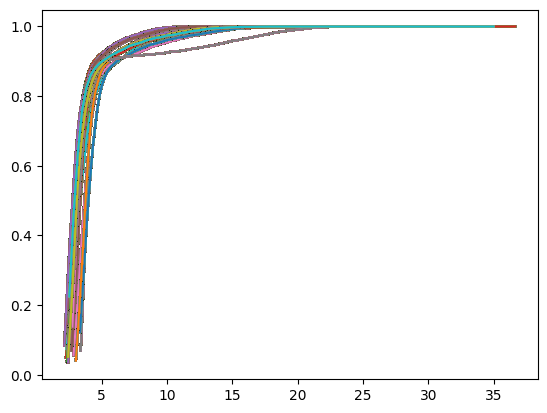

In [21]:
#lambda = 0.013, 1 

num_of_for = 20


ae_loss = np.zeros(shape=(num_of_for,1))
f1_value = np.zeros(shape=(num_of_for,1))
total_loss = np.zeros(shape=(num_of_for,1))
prec_value = np.zeros(shape=(num_of_for,1))
recal_value = np.zeros(shape=(num_of_for,1))

TP_value = np.zeros(shape=(num_of_for,1))
FP_value = np.zeros(shape=(num_of_for,1))
FN_value = np.zeros(shape=(num_of_for,1))
TN_value = np.zeros(shape=(num_of_for,1))
Thres = np.zeros(shape=(num_of_for,1))                   

math.factorial(1234567) 
start = time.time() 

#mu_full = pd.DataFrame()
for i in range(0, num_of_for):
    np.random.seed(7)
    print(i)
    train_total_data_normal, test_total_data_normal, y_train_normal,y_test_normal, test_total_data, total_training_instances, train_total_data_normal,test_total_data, cc_data_full_final = real_data_sat(4000)
    z_vec, f1_score, precision_val, recall_val,  loss_val, ae_loss_val, TP_val, FP_val, FN_val, TN_val, energy_value, best_thres     =  dasknmixem(train_total_data_normal, test_total_data_normal, y_train_normal, y_test_normal, total_training_instances, 
                                                                                                                                                test_total_data, cc_data_full_final, n_epochs=50, z_dim=1,k_dim=3, lr=0.001, batch_size=1024, n_hidden1=25, n_hidden2=20, n_hidden3=10, n_layer1=10, lamda1=0.1, thres_point=0.99)    
    print("f1_score", f1_score,
          "FPR_avg =", (FP_val)/(FP_val+TN_val),
          "precision_avg =", precision_val,
          "recall_avg =", recall_val,
          "TP_avg=", TP_val,
          "FP_avg=", FP_val,
          "FN_avg=", FN_val,
          "TN_avg=", TN_val,
          "Best_Threshold=",best_thres)
        
    ae_loss[i] = ae_loss_val 
    f1_value[i] = f1_score
    
    total_loss[i] = loss_val 
    prec_value[i] = precision_val 
    recal_value[i] = recall_val
    
    TP_value[i] = TP_val 
    FP_value[i] = FP_val
    FN_value[i] = FN_val
    TN_value[i] = TN_val
    Thres[i] = best_thres           


print("f1_score_avg =", np.mean(f1_value),
      "f1_var=", np.var(f1_value),
      "precision_avg =", np.mean(prec_value),
      "recall_avg =", np.mean(recal_value),
      "FPR_avg =", np.mean(FP_value)/(np.mean(FP_value)+np.mean(TN_value)),
      "TP_avg=", np.mean(TP_value),
      "FP_avg=", np.mean(FP_value),
      "FN_avg=", np.mean(FN_value),
      "TN_avg=", np.mean(TN_value),
     "Thres_avg=",np.mean(Thres))

end = time.time() 
print(f"{end-start:.5f} sec")

(pd.DataFrame(f1_value)).to_csv("DASKNMIX_sat_F1.csv")